In [0]:
# connects colab to drivefrom google.colab import drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import math
from collections import defaultdict, OrderedDict
import statistics
import copy

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None): 
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.constant_pitch()
    self.find_gamaka()
    self.find_stationary_points()
    self.develop_histogram(cpn = True)
    self.tonic = self.find_tonic()
    self.develop_histogram(cpn = False)
    self.histogram()
    self.normalize()
    self.find_all_notes()
    self.sequence_notes = self.find_sequence_notes()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)

  def constant_pitch(self ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
  
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):  
    self.all_notes = []
    for i in self.n_pitch:
      if i in self.n_cpn or i in self.n_stp:
        self.all_notes.append(i)

  def find_gamaka(self):
    
    ta = list(self.time_axis)
    bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        bt_cpt.append([init,j[0]])
        init = j[-1]
    bt_cpn_cpt=[]
    for i in bt_cpt:
          begin = int(100*i[0])
          end = int(100*i[1])
          bt_cpn_cpt.append((self.pitch[begin:end],ta[begin:end]))
    self.bt_cpn_cpt = np.array(bt_cpn_cpt)
    self.bt_cpn,self.bt_cpt = self.bt_cpn_cpt.T
  
  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])

  def develop_histogram(self,cpn):
    if(cpn):
      values=[x for x in self.cpn if (math.isnan(x) == False)]
    else:
      values = [x for x in self.pitch if (math.isnan(x) == False)]
    values=[round(x,0) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=100
    while(j<=500):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=1
    
  def find_tonic(self):
    # print("hi")
    def tonic_candidates_f():
        #histo is a dictionary
        candidates=defaultdict(int)
        local_histo = copy.deepcopy(self.d_hist)

        for i in range(20):
          highest=0
          freq = 0
          for i in local_histo:
            if(local_histo[i]>highest):
              highest = local_histo[i]
              freq=i
          candidates[freq] = highest
          del local_histo[freq]  
        # print("occurances for 298 :",histo[298])
        # print("The candidates are : ",candidates.keys())
        return(candidates.keys())

    
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
    def close(arr):
      flag=0
      min_diff =45000
      ele1=0;ele2=0
      for i in range(len(arr)):
        for j in range(i+1,len(arr)):
          if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
            ele1=arr[i]
            ele2=arr[j]
            flag=1
      if(flag==0):    
        return min(arr)
      return(ele1,ele2) 
    
    def half_the_Sa(ton):

      if(ton>230):
        return (ton/2)
      else:
        return ton
  
    self.Sa_candidates=defaultdict(list)
    tonic_candidates=tonic_candidates_f()
    for i in tonic_candidates:
      for j in tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              self.Sa_candidates["Pa"].append(j)
            if(((i/j)>1.06) and ((i/j) <1.08)):
              self.Sa_candidates["Ri1"].append(j)
            if(((i/j)>1.19) and ((i/j) <1.21)):
              self.Sa_candidates["Ga2"].append(j)
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              self.Sa_candidates["Ri2"].append(j)

            if(((i/j)>1.4) and ((i/j) <1.42) ):
              self.Sa_candidates["Ma2"].append(j)
              
            if(((i/j)>1.31) and ((i/j) <1.34) ):
              self.Sa_candidates["Ma1"].append(j)
             
            if(((i/j)>1.23) and ((i/j) <1.27)):
              self.Sa_candidates["Ga3"].append(j)
            if(((i/j)>1.57) and ((i/j) <1.62)):
              self.Sa_candidates["Da1"].append(j)
              
            if(((i/j)>1.86) and ((i/j) <1.91) ):
              self.Sa_candidates["Ni3"].append(j)
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              self.Sa_candidates["Ni2"].append(j)
              
            if(((i/j)>1.98) and ((i/j) <2.2) ):
              self.Sa_candidates["High_Sa"].append(j)
    # print("The Sa_candidates are : ",(Sa_candidates))  
    if("Pa" in self.Sa_candidates):
        if("High_Sa" not in self.Sa_candidates):
          self.Sa_candidates["High_Sa"] =[0]   
          High_Sa=0
        else:
          if(len(self.Sa_candidates["High_Sa"])!=0):
            High_Sa = mean(remove_outliers(self.Sa_candidates["High_Sa"]))
        if(len(self.Sa_candidates["Pa"])!=0):
          Pa = mean(remove_outliers(self.Sa_candidates["Pa"]))
        if(abs(High_Sa-Pa)<3 and (High_Sa+Pa) != 0):
          return(half_the_Sa(min(High_Sa,Pa)))     
          a=5
    without_pa=[]
    for i in self.Sa_candidates:
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if (self.Sa_candidates[i]):
        if(len(self.Sa_candidates[i])==1):
          a=5
        if(len(self.Sa_candidates[i])==0):
          self.Sa_candidates[i].append(0)
          # without_pa.append(Sa_candidates[i][0])
        elif(len(self.Sa_candidates[i])!=0):
            self.Sa_candidates[i]=remove_outliers(self.Sa_candidates[i])
          # without_pa.extend(Sa_candidates[i])
      
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
        if(len(self.Sa_candidates[i])!=0):
          self.Sa_candidates[i]=mean(self.Sa_candidates[i])
          
    # print("without_pa : ",remove_outliers(without_pa))  
    
    # print(list(Sa_candidates.values()))

 
    temp=[i for i in list(self.Sa_candidates.values()) if(i)]
    # print("Temp :",temp)
    finallist=remove_outliers(temp)
    # print("Sa_candidates : ", finallist)
    two_tonic=close(finallist)
    # print("two_tonic :",two_tonic)
    if(type(two_tonic) ==tuple):
      # print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
      return(half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    else:
      # print("Tonic : ",half_the_Sa(two_tonic))
      return(half_the_Sa(two_tonic))
  
  def histogram(self):
    self.hist_bins,self.hist_y = np.array(list(self.d_hist.items())).T
  
  def normalize(self):
    self.n_pitch = [12*np.log2(i/self.tonic) for i in self.pitch]
    self.n_hist_y = self.hist_y/self.tonic
    self.n_bt_cpn = [12*np.log2(j/self.tonic) for i in self.bt_cpn for j in i]
    self.n_stp = [12*np.log2(i/self.tonic) for i in self.stp]
    self.n_cpn = [12*np.log2(i/self.tonic) for i in self.cpn]
  
  def find_sequence_notes(self):
    notes = []
    for k in self.all_notes:
      # min = 40
      if k in self.n_cpn:
        a = 0.04
      else:
        a = 0.135
      for i,j in all_normalized_notes.items():
        if (math.isclose(j,k,abs_tol= a)):
          notes.append(i)
    set_note = []
    initial = notes[0]
    set_note.append(initial)
    for i in range(1,len(notes)):
      if (initial != notes[i]):
        initial = notes[i]
        set_note.append(initial)
    return set_note

  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.n_pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.n_cpn,c='0',label = 'Constant Pitch')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.n_stp,c='#00FF00',label = 'Stationary Points')
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
      if(key =='histogram' and value):
        plt.plot(self.hist_bins,  self.n_hist_y,label = "histogram")
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


ratios = {'Sa0':1,'Ri1':16/15,'Ri2':9/8,'Ga2':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa0':3/2,'Da1':8/5,
          'Da2':5/3,'Ni2':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)
  all_normalized_notes['l'+i] = 12*np.log2(0.5*j)
  all_normalized_notes['h'+i] = 12*np.log2(2*j)

del all_normalized_notes['lSa2']
del all_normalized_notes['hSa0']
all_normalized_notes = OrderedDict(sorted(all_normalized_notes.items(),key=lambda kv: kv[1]))

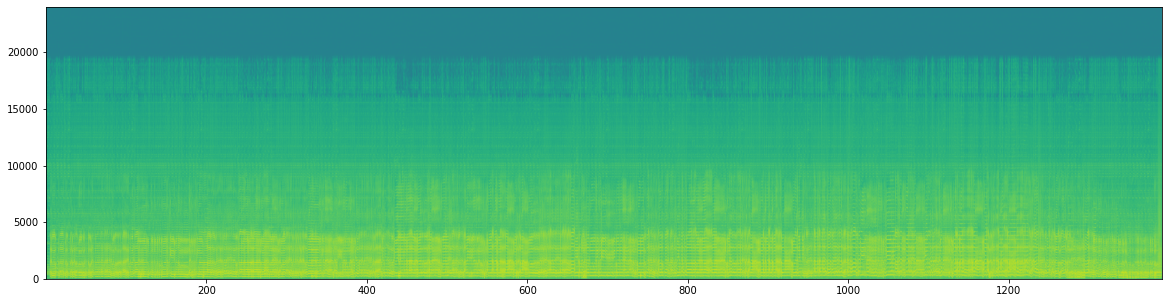

In [0]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')
kalyani_1 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
kalyani_2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')
kalyani_0 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_0.wav')
abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/abhogi.mp3')
kambhoji = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/kambhoji.mp3')
mayamalavagowlai= Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/mayamalavagowlai.mp3')
shanmukhapriya = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/shanmukhapriya.mp3')
trichur_kalyani = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/trichur_kalyani.mp3')
# rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
# rkm_kalyani=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
# rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
# rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
# rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
# rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')

In [0]:
def countme(l,sl):
  count =0
  for i in range(0,len(l)):
    a=l[i:i+len(sl)]
    if (a==sl):
      count+=1
  return(count)

def pattern(s):
  cnt=0
  d=dict()
  for sublen in range(3,int(len(s)/10)):
    for i in range(0,len(s)-sublen):
      sub = s[i:i+sublen]
      if(len(set(sub))>1):
        # print("sub :",sub)
        cnt = countme(s,sub)
        # print("cnt :",cnt)
        str1=""
        strsub=str1.join(sub)
        if cnt >= 10 and strsub not in d:
          d[strsub] = cnt
          #  print("hi")
  return d

In [0]:
sub = []
for i in s_1.keys():
  if i in p_1.keys():
    sub.append((i,p_1[i],s_1[i]))

In [0]:
sub

[('Ma2Pa0Ma2', 7, 21),
 ('hGa2hGa3hGa2', 3, 15),
 ('Da2Sa2Ni3', 2, 13),
 ('Pa0Ma2Pa0', 8, 35),
 ('Pa0Ma2Pa0Ma2', 4, 15)]